TP n°2 : prédiction à l'échelle du pixel - cas faiblement supervisés

**TP n°2**
Notions abordées:

En partie I:
- Test d'un FCN-ResNet sur un problème de segmentation sémantique. Métriques adaptées.
- Appentissage parfaitement supervisé d'un U-Net sur un problème de débruitage. 

En partie II:
- Le scénario noise-to-noise
- Neural Eggs Separation (cas simplifié)

Durée : 4 h

## Partie I: segmentation sémantique avec un FCN.  

Cette partie permet de se familiariser avec une tâche de segmentation sémantique. Cette tâche est abordée ici avec un FCN (Fully Convolutional Network) qui correspondait à [l'état de l'art en 2015](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k).


Par définition, un *Fully Convolutional Network* (FCN) ne contient pas de couches complètement connectées. En conséquence, la sortie conserve des dimensions spatiales. \\
Cette configuration est utile lorsque la cible de l'apprentissage est elle-même une image. C'est le cas pour des tâches de:
- segmentation sémantique. Il s'agit alors d'affecter à chaque pixel une classe sémantique (typiquement sol, ciel, nuages, bâtiments, etc).
- régression par pixel
- débruitage d'image
- super-résolution
- etc


Le premier exercice met en scène un FCN construit à partir d'un ResNet50 sur une tâche de segmentation simple, définie à partir d'un jeu d'images réelles segmentées à la main.

Le second exercice propose une tâche de régression par pixel complètement supervisée, définie sur une jeu d'images de synthèse générées à la volée.

**Exercice 1** Segmentation avec un FCN-ResNet 

**A.** Présentation du jeu de données

Dans les cellules suivantes, on charge les bib. utiles, on télécharge le jeu d'image segmentées préparé pour le challenge [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/segexamples/index.html) et on visualise des couples entrées-cibles du jeu d'entraînement:

In [1]:
#imports de base et montage du drive
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Se placer dans le rép courant après avoir complété son répertoire data
# (le dossier vocdevkit et deux fichiers .tar à ajouter)
os.chdir('drive/MyDrive/tp2_ml') 

In [4]:
# dataset pour visualiser (pas de normalisation ni de mise au format torch.tensor)

# needDownload à True pour la première fois, False ensuite
needDownload = False
input_resize = transforms.Resize((128, 128))
target_resize = transforms.Resize((128, 128))

train_dataset_viz = datasets.VOCSegmentation(
    './data', 
    year='2007',
    image_set='train',
    transform=input_resize,
    target_transform=target_resize,
)

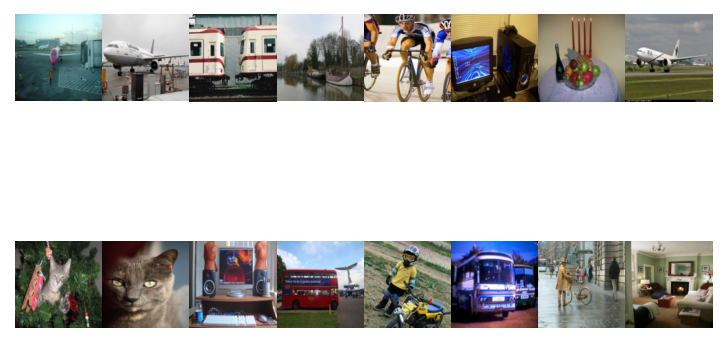

In [ ]:
import math

def plot_images(images, num_per_row=8, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image)
        ax.axis('off')

    return fig

# Echantilonnage du dataset de viz:

inputs, ground_truths = list(zip(*[train_dataset_viz[i] for i in range(16)]))

_ = plot_images(inputs)

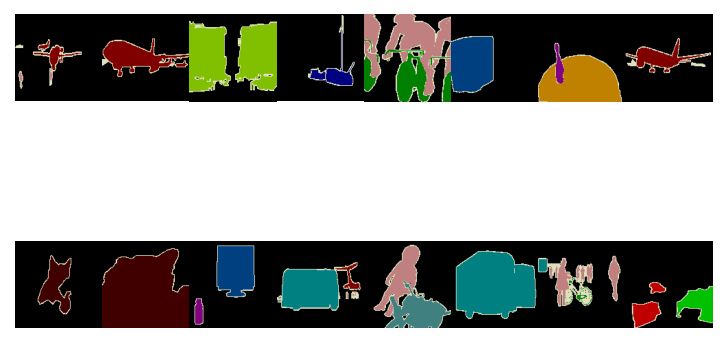

In [ ]:
_ = plot_images(ground_truths)

**Question 1** Combien y a-t-il de classes ? Quelle différence entre segmentation par objet et segmentation par classe ? De quelle type de segmentation s'agit-il ici ?

**B.** Présentation d'un FCN-ResNet

Dans la cellule suivante, nous chargeons un [FCN](https://pytorch.org/vision/stable/models/fcn.html) contruit à partir d'un [ResNet50](https://arxiv.org/pdf/1512.03385.pdf) : 

In [ ]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights_backbone = None )
# fcn = torchvision.models.segmentation.fcn_resnet50( weights_backbone = torchvision.models.ResNet50_Weights.IMAGENET1K_V1) 

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

**Q2.** Qu'est-ce qui change, par rapport à un ResNet50 standard ? Le FCN fournit-il une sortie de même taille
que l'entrée ? Tester et expliquer.

In [ ]:
resnet50 =  torchvision.models.resnet50()

...

In [ ]:
# Pour échantillonner le dataset avec conversion en torch.tensor:
batch_size = 4
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize([64,64])
target_resize = transforms.Resize((64,64))

input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)


# Creation d'un dataset
train_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=needDownload,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
inputs, targets  = next(iter(train_loader))

# conservation de la taille en sortie ?

...

torch.Size([4, 21, 64, 64])


**C.** Test d'un réseau préentraîné 

Dans cet exercice on se contente de **tester** un modèle entraîné sur un autre jeu de données de segmentation.
Un prolongement à cet exercice qui donne l'occasion d'entraîner le modèle contenu dans la fiche d'exercice n°2.
 

In [ ]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights='COCO_WITH_VOC_LABELS_V1') 

In [ ]:
# Pour le parcours de notre jeu de test :
batch_size = 16
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize((256,256))
target_resize = transforms.Resize((256,256))

input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)


target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
    ]
)

test_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=needDownload,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

# Creation des loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

**Q3** D'après les lignes de code qui précèdent, sur quel jeu (validation ou test) de PascalVOC2007 va-t-on tester le modèle ? Pourquoi ?

Visualisons quelques sorties du modèle sur ce jeu : 

In [ ]:
# Color palette for segmentation masks
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)


def array1d_to_pil_image(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [ ]:
inputs, targets = next(iter(test_loader))
outputs = fcn(inputs)['out']
outputs = outputs.argmax(1)

outputs = replace_tensor_value_(outputs, 21, 255)
targets = replace_tensor_value_(targets, 21, 255)
targets = targets.squeeze(dim=1)

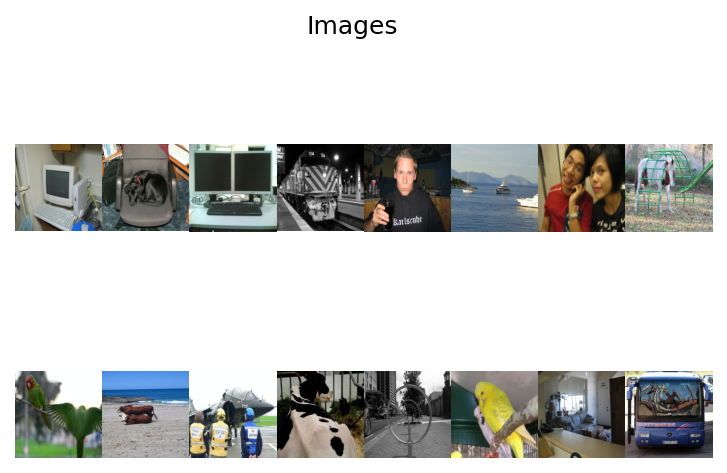

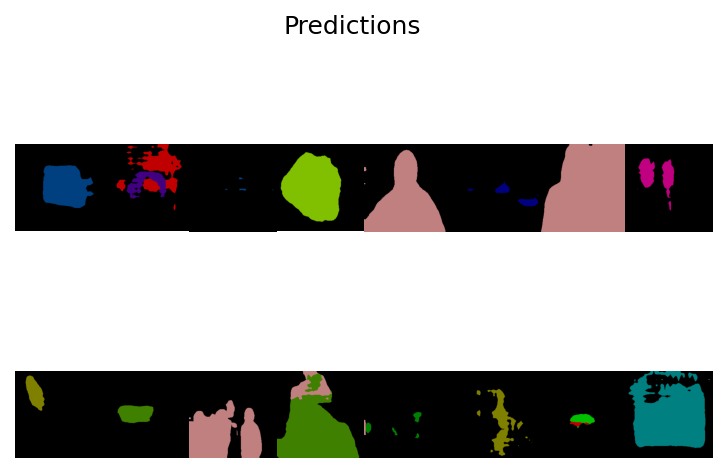

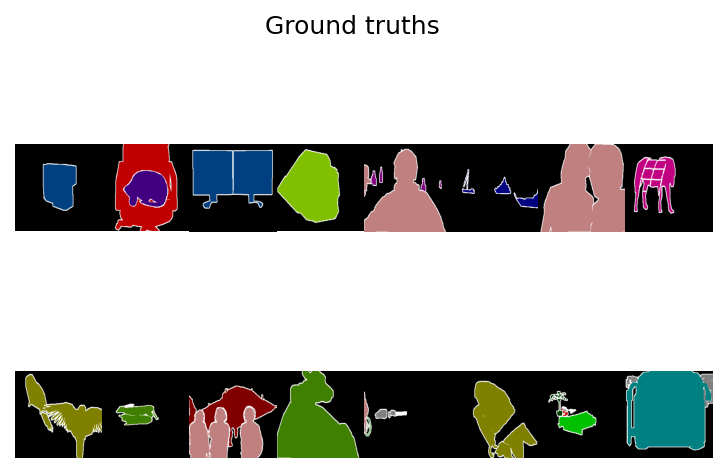

In [ ]:
plt_inputs = np.clip(inputs.numpy().transpose((0, 2, 3, 1)) * imagenet_std + imagenet_mean, 0, 1)
fig = plot_images(plt_inputs)
fig.suptitle("Images")

pil_outputs = [array1d_to_pil_image(out) for out in outputs.numpy()]
fig = plot_images(pil_outputs)
fig.suptitle("Predictions")

pil_targets = [array1d_to_pil_image(gt) for gt in targets.numpy()]
fig = plot_images(pil_targets)
_ = fig.suptitle("Ground truths")

Evaluons maintenant le modèle sur l'ensemble du jeu.

In [ ]:
# Pour la métrique du test:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.6 MB/s 


In [ ]:
import torchmetrics
IoU = torchmetrics.JaccardIndex(num_classes=21, ignore_index = 255)

**Q4** Plutôt que la justesse, c'est l'index de Jaccard qui va définir la métrique. Comment est-il défini ? Quel autre nom lui donne-t-on ? Quel est son avantage ?

**Q5** Modifier le code suivant pour obtenir une IoU moyenne sur l'ensemble du jeu

In [ ]:
fcn = fcn.cuda()
fcn.eval()

In [ ]:
for i, (inputs, targets) in enumerate(test_loader):
  print(i)
  targets = targets.squeeze(dim=1)
  targets[targets==255]= 0
  inputs = inputs.cuda()
  targets = targets.cuda()
  outputs = fcn(inputs)['out']

  outputs = outputs.cpu()
  targets = targets.cpu()
  batch_IoU = IoU(outputs, targets)

  print(batch_IoU)
  
  del inputs
  del targets
  del outputs
  torch.cuda.empty_cache()


**Exercice 2**: Débruitage parfaitement supervisé \\

Dans un problème de débruitage parfaitement supervisé, on dispose de deux jeux d'images $B_{noisy}$ et $B_{clean}$. A chaque image propre de $B_{clean}$ correspond une version bruitée dans $B_{noisy}$.  

Dans exercice, nous allons entraîner un FCN à passer de la version bruitée à la version propre. Pour éviter d'avoir recours à un jeu de données réelles qui prendrait de la place sur le drive, nous travaillons sur des images de synthèse générées à la volée.  
Nous nous plaçons ainsi le cadre idéal où les jeux sont de taille infinie et où le surapprentissage n'est pas un risque à prendre en compte. Dans ce cadre, l'augmentation de donnée et l'étape de validation sont inutiles, ce qui simplifie les procédures d'apprentissage.  
Les cellules suivantes permettent de visualiser des données de $B_{noisy}$ et leur pendant "propres" de $B_{clean}$. La fonction $gen$ permet d'échantillonner des batches à la volée.

Monter le drive pour pouvoir importer **utile.py**. Changer le répertoire de travail à cet effet.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#On se branche au répertoire contenant utile.py:
os.listdir()
os.chdir('TP_2223_corr_P')

In [ ]:
os.listdir() 
from utile import *

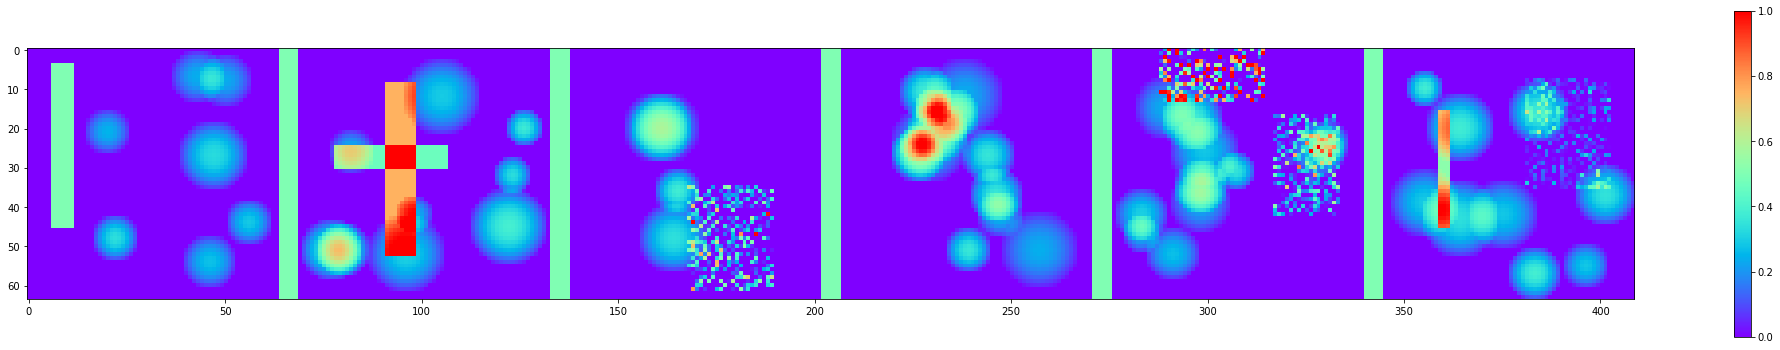

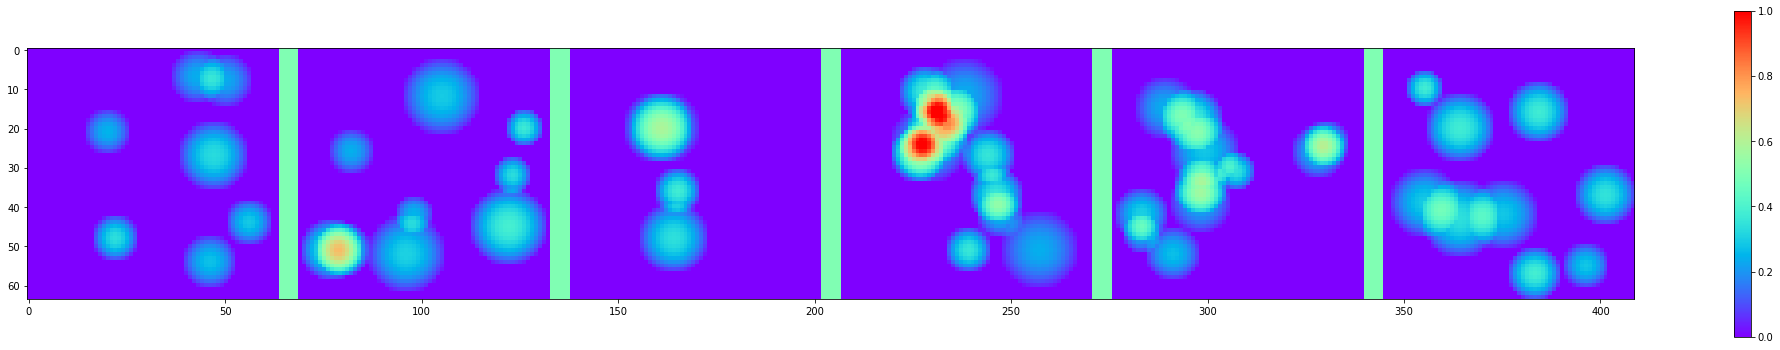

In [ ]:
input, target = gen(6) 

#versions bruitées (rectangles pleins et bruités)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

#versions propres (cellules seules)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)


Il s'agit donc de retirer les rectangles (pleins ou non) de l'image. C'est un problème bien posé, mais difficile a priori: il est nécessaire d'utiliser le contexte spatial pour y parvenir.  
Pour l'aborder, nous allons utiliser un autre FCN assez populaire: un [U-Net](https://arxiv.org/abs/1505.04597)  simplifié (voir utile.py).

In [ ]:
ch_in = 1
ch_out = 1
size = 16

fcn = UNet(ch_in,ch_out,size).cuda()  #1 canal entrée, 1 canal de sortie, paramètre taille du réseau: 16

**Q1**: Combien ce U-Net contient-elle de couches de convolution? Combien de poids au total lorsque $size = 16$ ?

**Q2**: Pour une image d'entrée de dimension spatiales $64\times 64$, quelle est la dimension du signal intermédiaire?

**Q3**: Comment le traitement multi-échelle est-il assuré? A quoi servent les "skip-connections"?

**Q4**: Définir une procédure d'apprentissage simple (pas de validation) utilisant comme fonction de coût la MSE (Mean Square Error) et Adam comme méthode d'optimisation (learning rate de 0.001).  
Lorsque la procédure d'apprentissage est prête, associer un gpu au notebook et s'assurer que la tâche de débruitage est bien apprise.

In [ ]:
#vérification de la mise à disponibilité de la carte gpu:
print(torch.cuda.get_device_name(0))

fcn = fcn.cuda()

Tesla T4


In [ ]:
def criterion(output,target):
  return torch.mean((output-target)**2)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
nepochs = 40 #se faire un thé en attendant
nbatches = 100
batchsize = 32

train_losses = []


for epoch in range(nepochs):
    

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        
        # génération du batch
        ...

        # passage sur la carte gpu
        ...

        #optimizer à zéro et forward pass
        ...

        #calcul de la loss, calcul des gradients
        ...
        
        #MAJ des poids
        ...


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()     

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)    
    print('epoch loss : \n')
    print(epoch_loss)




In [ ]:
#visualisation:

fcn.eval()

target = make_batch(6, rec = 0., noisy_rec= 0., disc = 0.002).cuda()
noise =  make_batch(6, rec = 0.0003, noisy_rec= 0.0003, disc = 0.).cuda()
input = target + noise

output = fcn(input)



fig = plt.figure(0, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale=0,max_scale=1)
fig2 = plt.figure(1, figsize=(36, 6))  #seconde ligne: vérité terrain
voir_batch2D(target.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)
